In [9]:
import math
import pandas_datareader as web
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.timeseries import TimeSeries
from datetime import *

plt.style.use('fivethirtyeight')

Stock = "AAPL"
API_KEY = "2K412SNOUGH30X5E"
start_date = datetime(2018, 1, 1)
end_date = datetime(2020, 1, 1)

In [10]:
def getList(dict): 
    list = [] 
    for key in dict.keys(): 
        list.append(key) 
          
    return list

In [11]:
def printData(data): 
    tmp_data = []
    for key in data.keys():
        tmp_data.append(data[key])
        tmp_data[-1]["Date"] = key
    return pd.DataFrame(tmp_data)

In [12]:
def divideInterestRate(interestRate, divisor):
    return 100 * ((1 + interestRate / 100.0)**(1/float(divisor)) - 1)

# Loading the Data of the Stock

In [13]:
ts = TimeSeries(key=API_KEY, output_format='json')
stock_data, meta_data = ts.get_daily_adjusted(symbol=Stock, outputsize='full')
ts = TimeSeries(key=API_KEY, output_format='pandas')
stock_data_view, meta_data = ts.get_daily_adjusted(symbol=Stock, outputsize='full')
stock_data_view

1. open  2. high  3. low  4. close  5. adjusted close  \
date                                                                
2021-02-22   128.01  129.720  125.60    126.00         126.000000   
2021-02-19   130.24  130.710  128.80    129.87         129.870000   
2021-02-18   129.20  129.995  127.41    129.71         129.710000   
2021-02-17   131.25  132.220  129.47    130.84         130.840000   
2021-02-16   135.49  136.010  132.79    133.19         133.190000   
...             ...      ...     ...       ...                ...   
1999-11-05    84.62   88.370   84.00     88.31           0.679082   
1999-11-04    82.06   85.370   80.62     83.62           0.643017   
1999-11-03    81.62   83.250   81.00     81.50           0.626715   
1999-11-02    78.00   81.690   77.31     80.25           0.617103   
1999-11-01    80.00   80.690   77.37     77.62           0.596879   

              6. volume  7. dividend amount  8. split coefficient  
date                                                               
2021-02-22  102886922.0                 0.0                   1.0  
2021-02-19   87668834.0                 0.0                   1.0  
2021-02-18   96856748.0                 0.0                   1.0  
2021-02-17   97372199.0                 0.0                   1.0  
2021-02-16   80576316.0                 0.0                   1.0  
...                 ...                 ...                   ...  
1999-11-05    3721500.0                 0.0                   1.0  
1999-11-04    3384700.0                 0.0                   1.0  
1999-11-03    2932700.0                 0.0                   1.0  
1999-11-02    3564600.0                 0.0                   1.0  
1999-11-01    2487300.0                 0.0                   1.0  

[5361 rows x 8 columns]

Text(0, 0.5, 'Price [$]')

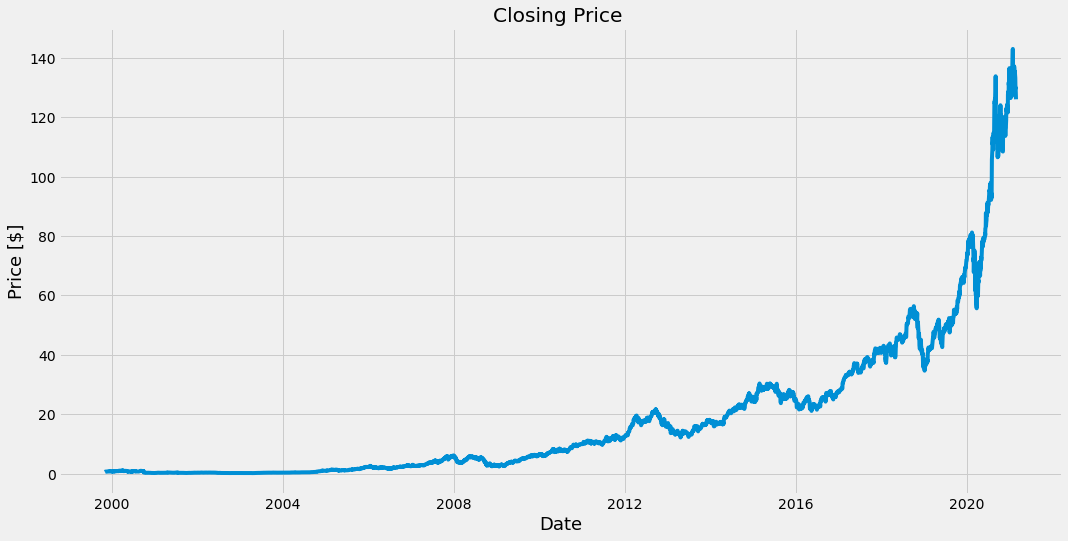

In [14]:
plt.figure(figsize=(16,8))
plt.title("Closing Price ")
plt.plot(stock_data_view['5. adjusted close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price [$]', fontsize=18)

Text(0, 0.5, 'Price [$]')

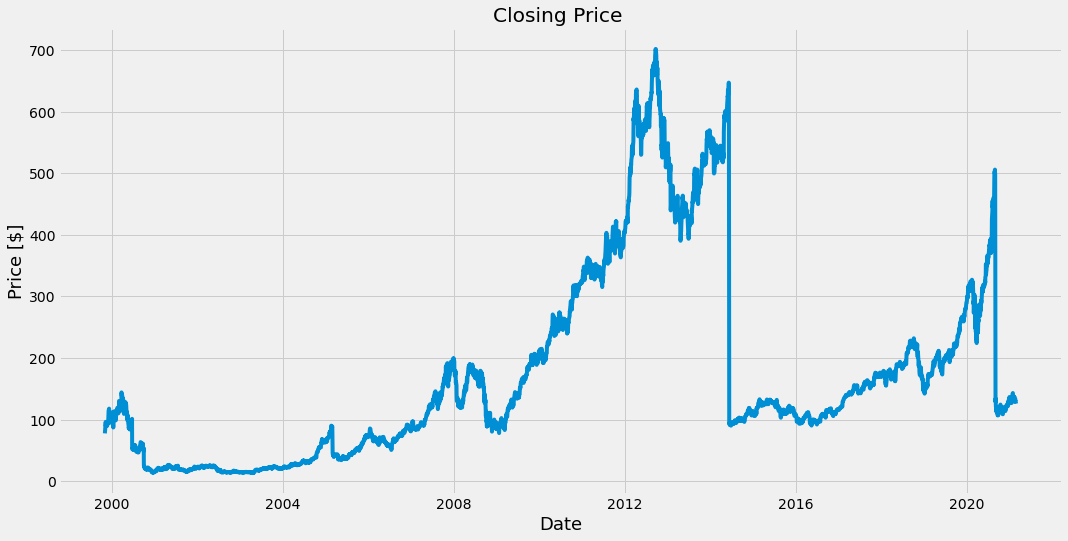

In [29]:
plt.figure(figsize=(16,8))
plt.title("Closing Price ")
plt.plot(stock_data_view['4. close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price [$]', fontsize=18)

# Get The market price of THE MSCI WORLD
As stocks in mulitble markets of different countries are used a makred that includes all has to be found. The MSCI World includes reprecentitive Stocks from over 28 different countries

In [15]:
msci_world_raw_data = pd.read_excel('tmp.xls')  

In [16]:
msci_world_raw_data

Unnamed: 0 Unnamed: 1
0                                                   NaN        NaN
1                                         Index Level :      Price
2                                            Currency :        USD
3                                                   NaN        NaN
4                                                   NaN        NaN
...                                                 ...        ...
1326  merchantability or fitness for a particular pu...        NaN
1327  in no event shall any of the MSCI Parties have...        NaN
1328  damages (including lost profits) even if notif...        NaN
1329  and all other service marks referred to herein...        NaN
1330  are the exclusive property of MSCI and may not...        NaN

[1331 rows x 2 columns]

In [17]:
msci_world={}
for i in range(len(msci_world_raw_data["Unnamed: 0"])):
    date_cell = str(msci_world_raw_data["Unnamed: 0"][i])
    try:
        date = datetime.strptime(date_cell, '%b %d, %Y')
        data_cell = msci_world_raw_data["Unnamed: 1"][i]
        data_cell = data_cell.replace(",","")
        msci_world[date] =float(data_cell)
    except:
        
        ##Cell is not a date cell
        ;


# Load Riskfree rate
As Ristfree rate a Daily Treasury Yield Curve Rates is used from https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield. The 10 year rate is taken. It was discount to a daily intresest rate

In [18]:
risk_free_raw_data = pd.read_csv('risk_free.csv')  

In [19]:
risk_free_rate={}
for i in range(len(risk_free_raw_data["Date"])):
    date_cell = str(risk_free_raw_data["Date"][i])
    date = datetime.strptime(date_cell, '%m/%d/%y')
    data_cell = risk_free_raw_data["10 Yr"][i]
    risk_free_rate[date] = divideInterestRate(float(data_cell),3650)

# Create new Dateset with needed data

In [20]:
capm_data={}
for key in stock_data.keys():
    date  = datetime.strptime(key, '%Y-%m-%d')
    if date >= start_date and date > end_date:
        capm_data[date] = {}
        capm_data[date]["Returns"] = float(stock_data[key]['5. adjusted close'])

# Calc Returns in  % and add excess market return

In [22]:
dateList = getList(capm_data)
dateList.sort()

x = []
y = []

for i in range(len(dateList)-1):
    date_before = dateList[i]
    date = dateList[i + 1]
    yesterday_returns = capm_data[date_before]["Returns"]
    today_returns = capm_data[date]["Returns"]
    return_in_percent = (today_returns - yesterday_returns)/yesterday_returns
    capm_data[date]["Returns [%]"] = return_in_percent * 100
    if date in msci_world and date in risk_free_rate:
        capm_data[date]["RMRF"] = ((msci_world[date] - msci_world[date_before])/msci_world[date_before])*100
        x.append(capm_data[date]["RMRF"])
        capm_data[date]["RF"] = risk_free_rate[date]
        capm_data[date]["Excess return"] = return_in_percent * 100 - risk_free_rate[date]
        y.append(capm_data[date]["Excess return"])

In [23]:
printData(capm_data)

Returns  Returns [%]       Date      RMRF        RF  Excess return
0    126.000000    -2.979903 2021-02-22       NaN       NaN            NaN
1    129.870000     0.123352 2021-02-19       NaN       NaN            NaN
2    129.710000    -0.863650 2021-02-18       NaN       NaN            NaN
3    130.840000    -1.764397 2021-02-17       NaN       NaN            NaN
4    133.190000    -1.610401 2021-02-16       NaN       NaN            NaN
..          ...          ...        ...       ...       ...            ...
282   75.035008     1.608633 2020-01-08  0.190397  0.000508       1.608125
283   73.847080    -0.470314 2020-01-07 -0.087249  0.000497      -0.470810
284   74.196034     0.796826 2020-01-06  0.058017  0.000491       0.796335
285   73.609494    -0.972199 2020-01-03 -0.539492  0.000489      -0.972688
286   74.332151          NaN 2020-01-02       NaN       NaN            NaN

[287 rows x 6 columns]

In [24]:
x_sm = sm.add_constant(x)
model = sm.OLS(y,x_sm)

In [25]:
results = model.fit()

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     403.6
Date:                Tue, 23 Feb 2021   Prob (F-statistic):           5.23e-56
Time:                        17:47:27   Log-Likelihood:                -561.30
No. Observations:                 279   AIC:                             1127.
Df Residuals:                     277   BIC:                             1134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1359      0.109      1.249      0.213      -0.078       0.350
x1             1.2411      0.062     20.090      0.000       1.120       1.363
==============================================================================
Omnibus:                       47.459   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.688
Skew:                           0.658   Prob(JB):                     1.92e-38
Kurtosis:                       6.635   Cond. No.                         1.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

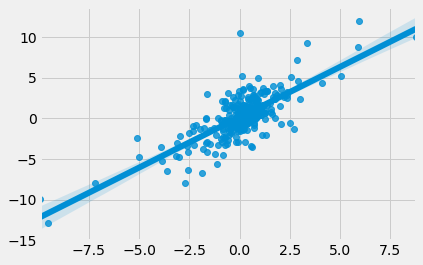

In [27]:
import seaborn as sns
sns.lw=0.1
sns.regplot(x=x,y=y);

# Sum it up in a Funktion

In [28]:
def getCAPM(stock, start_date, end_date): 
    ts = TimeSeries(key=API_KEY, output_format='json')
    stock_data, meta_data = ts.get_daily_adjusted(symbol=stock, outputsize='full')
    # MSIC WORLD
    msci_world_raw_data = pd.read_excel('tmp.xls')
    msci_world={}
    for i in range(len(msci_world_raw_data["Unnamed: 0"])):
        date_cell = str(msci_world_raw_data["Unnamed: 0"][i])
        try:
            date = datetime.strptime(date_cell, '%b %d, %Y')
            data_cell = msci_world_raw_data["Unnamed: 1"][i]
            data_cell = data_cell.replace(",","")
            msci_world[date] =float(data_cell)
        except:

            ##Cell is not a date cell
            ;
    # Risk free Rate
    risk_free_raw_data = pd.read_csv('risk_free.csv')
    risk_free_rate={}
    for i in range(len(risk_free_raw_data["Date"])):
        date_cell = str(risk_free_raw_data["Date"][i])
        date = datetime.strptime(date_cell, '%m/%d/%y')
        data_cell = risk_free_raw_data["10 Yr"][i]
        risk_free_rate[date] = divideInterestRate(float(data_cell),3650)
        
    capm_data={}
    for key in stock_data.keys():
        date  = datetime.strptime(key, '%Y-%m-%d')
        if date >= start_date and date > end_date:
            capm_data[date] = {}
            capm_data[date]["Returns"] = float(stock_data[key]['5. adjusted close'])
            
    dateList = getList(capm_data)
    dateList.sort()

    x = []
    y = []
    return_sum = 0
    rm_sum = 0
    rf_sum = 0
    local_start_date = None
    local_end_date = None
    for i in range(len(dateList)-1):
        date_before = dateList[i]
        date = dateList[i + 1]
        yesterday_returns = capm_data[date_before]["Returns"]
        today_returns = capm_data[date]["Returns"]
        return_in_percent = ((today_returns - yesterday_returns)/yesterday_returns) * 100
        if date in msci_world and date in risk_free_rate:
            if start_date is None:
                start_date = date     
            end_date = date
            x.append(((msci_world[date] - msci_world[date_before])/msci_world[date_before])*100)
            y.append(return_in_percent - risk_free_rate[date])
            return_sum = return_sum + return_in_percent
            rm_sum = rm_sum + ((msci_world[date] - msci_world[date_before])/msci_world[date_before])*100
            rf_sum = rf_sum + risk_free_rate[date]
            
    x_sm = sm.add_constant(x)
    model = sm.OLS(y,x_sm)
    results = model.fit()
    sns.regplot(x=x,y=y);
    
    delta = dateList[len(dateList)-1] - dateList[0]
    delta = float(delta.days)
    print(delta)
    return {"beta": results.params[1], "exp_return": return_sum/delta, "rm":rm_sum/delta, "rf": rf_sum/delta }

414.0


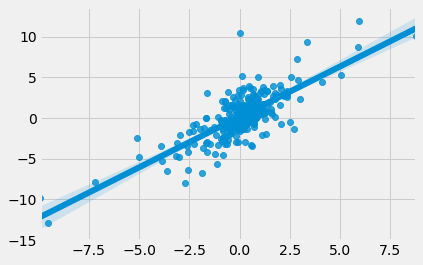

In [35]:
data_AAPL = getCAPM("AAPL", start_date, end_date)

414.0


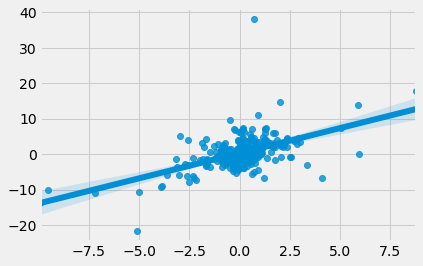

In [36]:
data_UBER = getCAPM("Uber", start_date, end_date)

414.0


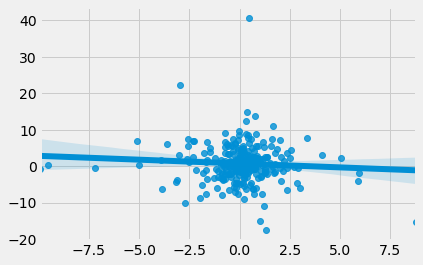

In [37]:
data_ZM = getCAPM("ZM", start_date, end_date)

414.0


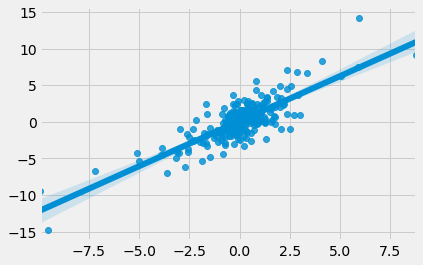

In [38]:
data_MSFT = getCAPM("MSFT", start_date, end_date)

414.0


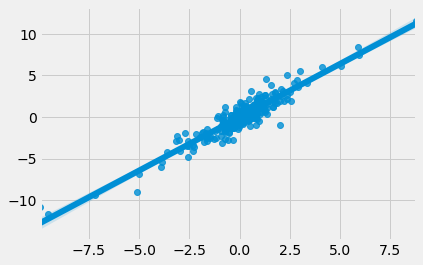

In [39]:
data_VOE = getCAPM("VOE", start_date, end_date)

414.0


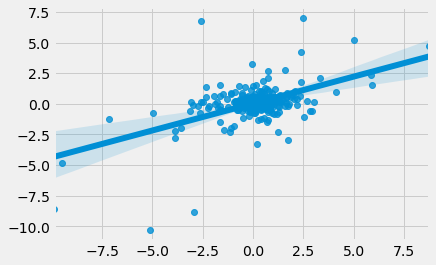

In [47]:
data_EVN = getCAPM("EVN", start_date, end_date)

414.0


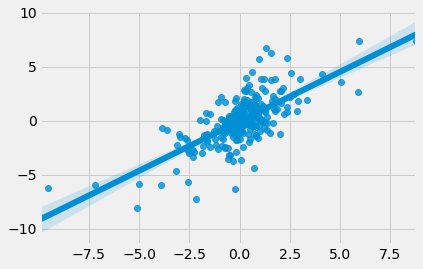

In [43]:
data_POST = getCAPM("POST", start_date, end_date)

In [48]:
date = datetime(2020, 1, 6)
rf = data_ZM["rf"]
rm = data_ZM["rm"]

In [49]:
print(rf)

0.00016685299550905732


[1.24111783 1.42043292 1.23162996 1.28473978 0.43942115 0.91686476]
[ 0.14994823  0.24291697  0.11617094  0.04327817  0.03797891 -0.00244942]
0.14994823285324016
0.058139664072051386
0.24291696798163673
0.06651550044405043
0.11617093880772342
0.05769648412854542
0.043278169067825
0.060177252546606774
0.0379789128533753
0.020692284548097427
-0.0024494198267812316
0.04299375177159203


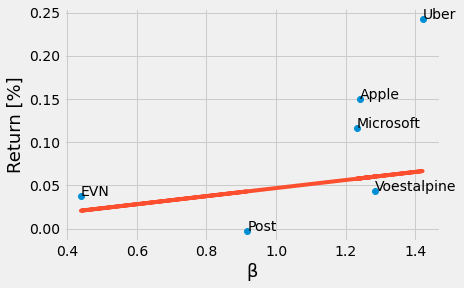

In [56]:
x = np.array([data_AAPL["beta"],data_UBER["beta"], data_MSFT["beta"],data_VOE["beta"],data_EVN["beta"],data_POST["beta"]])
y = np.array([data_AAPL["exp_return"],data_UBER["exp_return"],data_MSFT["exp_return"],data_VOE["exp_return"],data_EVN["exp_return"],data_POST["exp_return"]])
plt.plot(x, y, 'o')

print(x);
print(y);

plt.text(data_AAPL["beta"],data_AAPL["exp_return"],'Apple')
plt.text(data_UBER["beta"],data_UBER["exp_return"],'Uber')
plt.text(data_MSFT["beta"],data_MSFT["exp_return"],'Microsoft')
plt.text(data_VOE["beta"],data_VOE["exp_return"],'Voestalpine')
plt.text(data_EVN["beta"],data_EVN["exp_return"],'EVN')
plt.text(data_POST["beta"],data_POST["exp_return"],'Post')
plt.xlabel('β', fontsize=18)
plt.ylabel('Return [%]', fontsize=18)
plt.plot(x, rf + x * ( rm - rf ))
print( data_AAPL["exp_return"])
print(rf + data_AAPL["beta"] * ( rm - rf ))
print(data_UBER["exp_return"])
print(rf + data_UBER["beta"] * ( rm - rf ))
print(data_MSFT["exp_return"])
print(rf + data_MSFT["beta"] * ( rm - rf ))
print(data_VOE["exp_return"] )
print(rf + data_VOE["beta"] * ( rm - rf ))
print(data_EVN["exp_return"])
print(rf + data_EVN["beta"] * ( rm - rf ))
print(data_POST["exp_return"])
print(rf + data_POST["beta"] * ( rm - rf ))